In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

In [2]:
@numba.njit
def lowerTriangularDistMatrix(positions: np.ndarray, numberOfParticles: int, boxSize: float):
    dist = np.zeros(int(0.5 * numberOfParticles * (numberOfParticles - 1)))
    counter = 0
    for i in range(numberOfParticles - 1):
        for j in range(i + 1, numberOfParticles):
            dr = positions[i] - positions[j]
            dr = (dr + 0.5 * boxSize) % boxSize - 0.5 * boxSize
            dist[counter] = np.sqrt(np.sum(dr**2))
            counter += 1
    return dist

@numba.njit
def checkOverlap(newPosition: float, positions: np.ndarray, boxSize: float, particleIdx: int):
    dr = newPosition - positions
    dr = (dr + 0.5 * boxSize) % boxSize - 0.5 * boxSize
    d = np.sqrt(np.sum(dr**2, axis=-1))
    d[particleIdx] = np.inf

    # exclude 0, because that is the same particle
    return np.any(d < 1.0)

@numba.njit
def dynamicHardDisks(
        numberOfInitCycles: int, 
        numberOfProdCycles: int, 
        numberOfParticles: int, 
        maxDisplacement: float, 
        sampleFrequency: int,
        boxSize: float,
        rdfBins: int, 
    ):
    
    
    latticeSites = int(boxSize)
    nLattice = latticeSites**2
    positions = np.zeros((nLattice, 2))
    
    count = 0
    for x in np.linspace(0, (1-1/latticeSites) * boxSize, latticeSites):
        for y in np.linspace(0, (1-1/latticeSites) * boxSize, latticeSites):
            positions[count] = np.array([x,y])
            count += 1
    positions = positions[np.random.choice(nLattice, nLattice, replace=False)[:numberOfParticles]]

    numberOfSamples = numberOfProdCycles // sampleFrequency
    samplePositions = np.zeros((numberOfSamples, numberOfParticles, 2))
    sampleCounter = 0

    rdf = np.zeros(rdfBins)
    
    numberOfAttemptedMoves = 0
    numberOfAcceptedMoves = 0
    
    for cycle in range(numberOfInitCycles + numberOfProdCycles):
        numberOfAttemptedMoves += 1
        displacement = (np.random.rand(2) - 0.5) * maxDisplacement
        particleIdx = np.random.choice(numberOfParticles)
        newPosition = positions[particleIdx] + displacement
        
        overlap = checkOverlap(newPosition, positions, boxSize, particleIdx)
        if not overlap:
            positions[particleIdx] = newPosition
            numberOfAcceptedMoves += 1
                
        if cycle >= numberOfInitCycles and cycle % sampleFrequency == 0:
            samplePositions[sampleCounter] = positions
            sampleCounter += 1

            dist = lowerTriangularDistMatrix(positions, numberOfParticles, boxSize)
            hist, edges = np.histogram(dist, bins=rdfBins, range=(0, 0.5 * boxSize))
            rdf += 2 * hist

    areaNorm = np.pi * (edges[1:]**2 - edges[:-1]**2)
    r2 = numberOfParticles * (numberOfParticles - 1) * areaNorm
    rdf *= boxSize**2 / (r2 * sampleCounter)
    print(numberOfAcceptedMoves/numberOfAttemptedMoves)
    return samplePositions % boxSize, rdf


@numba.njit
def staticHardDisks(
        numberOfInitCycles: int, 
        numberOfProdCycles: int, 
        numberOfParticles: int, 
        maxDisplacement: float, 
        sampleFrequency: int,
        boxSize: float,
        rdfBins: int, 
    ):
    
    latticeSites = int(boxSize)
    nLattice = latticeSites**2
    positions = np.zeros((nLattice, 2))
    
    count = 0
    for x in np.linspace(0, (1-1/latticeSites) * boxSize, latticeSites):
        for y in np.linspace(0, (1-1/latticeSites) * boxSize, latticeSites):
            positions[count] = np.array([x,y])
            count += 1
    positions = positions[np.random.choice(nLattice, nLattice, replace=False)[:numberOfParticles]]

    numberOfSamples = numberOfProdCycles // sampleFrequency
    samplePositions = np.zeros((numberOfSamples, numberOfParticles, 2))
    sampleCounter = 0

    rdf = np.zeros(rdfBins)
    
    numberOfAttemptedMoves = 0
    numberOfAcceptedMoves = 0

    for cycle in range(numberOfInitCycles + numberOfProdCycles):
        numberOfAttemptedMoves += 1
        
        newPositions = np.random.rand(numberOfParticles, 2) * boxSize

        overlap = False
        for i in range(numberOfParticles - 1):
            for j in range(i + 1, numberOfParticles):
                r2 = np.sum((newPositions[i] - newPositions[j])**2, axis=-1)
                if (r2 < 1.0):
                    overlap = True
                    break
            if overlap:
                break
        
        if not overlap:
            positions = newPositions
            numberOfAcceptedMoves += 1

        if cycle >= numberOfInitCycles and cycle % sampleFrequency == 0:
            samplePositions[sampleCounter] = positions
            sampleCounter += 1

            dist = lowerTriangularDistMatrix(positions, numberOfParticles, boxSize)
            hist, edges = np.histogram(dist, bins=rdfBins, range=(0, 0.5 * boxSize))
            rdf += 2 * hist

    areaNorm = np.pi * (edges[1:]**2 - edges[:-1]**2)
    r2 = numberOfParticles * (numberOfParticles - 1) * areaNorm
    rdf *= boxSize**2 / (r2 * sampleCounter)
    print(numberOfAcceptedMoves/numberOfAttemptedMoves)
    return samplePositions % boxSize, rdf


In [3]:
boxSize = 20.0
x, rdf = dynamicHardDisks(
    numberOfInitCycles = int(1e6), 
    numberOfProdCycles = int(1e6), 
    numberOfParticles = 64, 
    maxDisplacement = 2.0, 
    sampleFrequency = 5000,
    boxSize = boxSize,
    rdfBins = 100
)

0.75301


(0.0, 20.0)

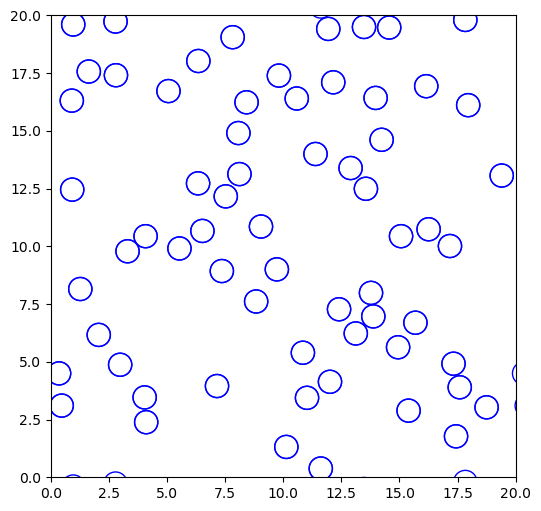

In [4]:
fig, ax = plt.subplots(figsize=(6,6))
#ax.scatter(*x[-1].T % boxSize, s=1200)
plusX = np.array([boxSize, 0])
plusY = np.array([0, boxSize])

for pos in x[-1]:
    ax.add_patch(plt.Circle(pos, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos + plusX, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos - plusX, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos + plusY, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos - plusY, 0.5, edgecolor="blue", fill=False))
ax.set_xlim(0, boxSize)
ax.set_ylim(0, boxSize)

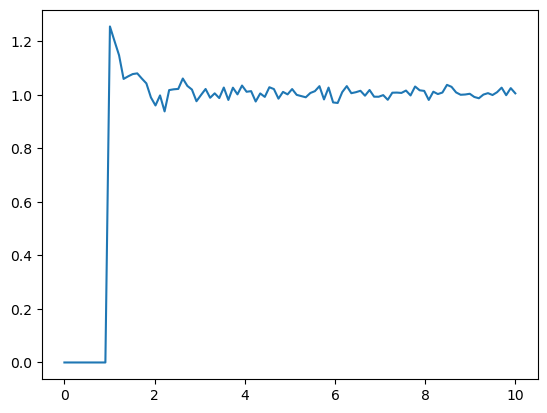

In [5]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0.0, 0.5 * boxSize, 100), rdf)

In [6]:
boxSize = 20.0
x, rdf = staticHardDisks(
    numberOfInitCycles = int(1e6), 
    numberOfProdCycles = int(1e6), 
    numberOfParticles = 32, 
    maxDisplacement = 0.2, 
    sampleFrequency = 5000,
    boxSize = boxSize,
    rdfBins = 100
)

0.019931


(0.0, 20.0)

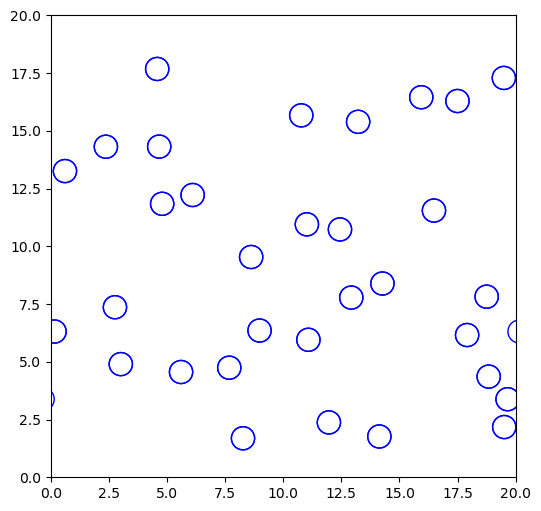

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
#ax.scatter(*x[-1].T % boxSize, s=1200)
plusX = np.array([boxSize, 0])
plusY = np.array([0, boxSize])

for pos in x[-1]:
    ax.add_patch(plt.Circle(pos, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos + plusX, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos - plusX, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos + plusY, 0.5, edgecolor="blue", fill=False))
    ax.add_patch(plt.Circle(pos - plusY, 0.5, edgecolor="blue", fill=False))
ax.set_xlim(0, boxSize)
ax.set_ylim(0, boxSize)